In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import IPython.display as ipd
from ipynb.fs.defs.utility import *
from dataclasses import dataclass

In [125]:
FS = 48000 # the audio output sample rate

def num_samples_for_secs(s):
    return int(FS * s)

# min frequency of each oscillator
VCO_F_MIN, VCO_F_MAX = 40, 20000
LFO_F_MIN, LFO_F_MAX = 1/60, 1000

# wavetable shape indices
WAVE_SIN, WAVE_TRI, WAVE_SAW, WAVE_SQR = 0, 1, 2, 3

# import the wavetable settings
with open("wavetable_meta.dat") as wt_meta_file:
    consume_line = lambda : int(wt_meta_file.readline())
    SMPL_SIZE = consume_line()
    NUM_OCTAVES = consume_line()
    NUM_WAVES = consume_line()
        
# import the wavetable
with open("wavetable_init.dat") as wt_file:
    wavetable = [float(x) for x in wt_file.read().split(',\n')]

In [115]:
def sample(wave_idx, octave_idx, sample_idx):
    i,j,k = wave_idx, octave_idx, sample_idx
    return wavetable[SMPL_SIZE*((NUM_OCTAVES*i)+j) + k]

# returns a sample from the wave table for wave with frequency f and sample index k
# - k in range [0, SMPL_SIZE]
def wt_sample(wave_idx, f, k):
    # select adjacent band-limited wavetables for a given waveshape that bound the input frequency
    wt_idx = int(np.log2(int(f/VCO_F_MIN))) + 1 # select the wavetable that lower bounds the input frequency
    wt_idx_plus_1 = min(wt_idx+1, NUM_OCTAVES-1) # adjacent wavetable must not be out of bounds    
    
    # interpolation parameters
    x0 = int(k)
    x1 = x0 + 1
    p_lo = VCO_F_MIN*(2**(wt_idx-1))
    p_weight = translate_range(f, p_lo, p_lo*2, 0, 1)
        
    # interpolate between adj BL tables at x = x0
    # to get point (x0, y0)
    px0_1 = sample(wave_idx, wt_idx, x0)
    px0_2 = sample(wave_idx, wt_idx_plus_1, x0)
    y0 = lerp1d(px0_1, px0_2, p_weight)
    
    # interpolate between adj BL tables at x = x1
    # to get point (x1, y1)
    px1_1 = sample(wave_idx, wt_idx, x1 % SMPL_SIZE)
    px1_2 = sample(wave_idx, wt_idx_plus_1, x1 % SMPL_SIZE)
    y1 = lerp1d(px1_1, px1_2, p_weight)
            
    # interpolate between points (x0,y0) and (x1,y1) at x = k
    # - could also do (0,y0) and (1,y1) at x = k-int(k)
    y = lerp2d(x0, y0, x1, y1, k)
    
    return y

In [124]:
def gen_output(cv_stream_collection, N, show_progress=False):
    total_samples = N
    wave_out = []
    k = 0 # track the (decimal) index of the wave sample
        
    for i in range(0, total_samples):
          
        # get the cv snapshot for this sample
        cv_ss = cv_stream_collection.get_snapshot_at(i)
        wave_idx = cv_ss.get_channel(CV_CH_WAVE_IDX)
        mode = cv_ss.get_channel(CV_CH_MODE)
        coarse_adj = cv_ss.get_channel(CV_CH_COARSE_ADJ)
        fine_adj = cv_ss.get_channel(CV_CH_FINE_ADJ)
        vpo = cv_ss.get_channel(CV_CH_VPO)
        fm_exp = cv_ss.get_channel(CV_CH_FM_EXP)
    
        # determine the frequency - this would be done during idle time in firmware
        f = translate_range(coarse_adj, 0, 1, VCO_F_MIN, VCO_F_MAX)
        volt_from_vpo = translate_range(vpo, -1, 1, -5, 5)
        f *= 2**volt_from_vpo
        volt_from_fm = translate_range(fm_exp, -1, 1, -5, 5)
        f *= 2**volt_from_fm
        
        # clamp the frequency to within capable range - SHOULDN'T HAVE TO DO THIS
        f = clamp(f, VCO_F_MIN, VCO_F_MAX) # restrict f to range [VCO_F_MIN, VCO_F_MAX]
    
        # take two samples from different waveshapes and interpolate between them based on CV
        wave_shape = wave_idx
        wave_shape_floor = int(wave_shape)
        y1 = wt_sample(wave_shape_floor, f, k)
        
        y2 = wt_sample(min(wave_shape_floor + 1, NUM_WAVES-1), f, k)
        y = lerp1d(y1, y2, wave_shape % 1)
        wave_out.append(y)   
        
        # get the desired frequency for this sample and adjust the playback rate     
        playback_rate = SMPL_SIZE * f / FS 
    
        # update the (decimal) index in the wave sample
        k += playback_rate
        k %= SMPL_SIZE
        
        if show_progress:
            prog = 100*i/total_samples
            if prog % 10 == 0:
                print(prog, "%")

    return np.array(wave_out)

In [123]:
### TESTS ####

# note: in C, we'd also have to keep size as a parameter
CV_CH_WAVE_IDX = 0
CV_CH_MODE = 1
CV_CH_COARSE_ADJ = 2
CV_CH_FINE_ADJ = 3
CV_CH_VPO = 4
CV_CH_FM_EXP = 5

@dataclass
class CV_stream:
    # stream of CV values for a single channel for many samples
    cv_stream: [float]
        
    def get(self, i):
        if i < 0 or i >= len(self.cv_stream):
            return 0
        return self.cv_stream[i]
    
    def size(self):
        return len(self.cv_stream)  

class CV_stream_collection:
    def __init__(self, num_channels):
        self.num_channels = num_channels
        self.cv_collection = [None] * num_channels

    def __post_init__(self):
        self.cv_collection = [] * self.num_channels
        
    def add_stream(self, channel, stream):
        self.cv_collection[channel] = stream
        
    def get_snapshot_at(self, i):
        return CV_snapshot([stream.get(i) for stream in self.cv_collection])

@dataclass
class CV_snapshot:
    # snapshot in time of CV values across all channels
    cv_values: [float]
        
    def get_channel(self, channel):
        if channel < 0 or channel >= len(self.cv_values):
            return 0
        return self.cv_values[channel]
    
def const_inp(val, size):
    return [val] * size

def gen_test(test_dict, N, listen_=True, plot=True):
    cv_col = CV_stream_collection(num_channels=len(test_dict))
    
    for k in test_dict.keys():
        ch = None
        if k == 'wave_idx':
            ch = CV_CH_WAVE_IDX
        elif k == 'mode':
            ch = CV_CH_MODE
        elif k == 'coarse_adj':
            ch = CV_CH_COARSE_ADJ
        elif k == 'fine_adj':
            ch = CV_CH_FINE_ADJ
        elif k == 'vpo':
            ch = CV_CH_VPO
        elif k == 'fm_exp':
            ch = CV_CH_FM_EXP
        cv_col.add_stream(ch, CV_stream(test_dict[k]))
                
    wave = gen_output(cv_col, N)
    if listen_:
        display(ipd.Audio(wave, rate=FS))
    if plot:
        plt.plot(wave)

In [118]:
###### TEST FREQUENCY SWEEP ######
N = num_samples_for_secs(3)
test_dict = {
    'wave_idx': const_inp(WAVE_SIN, N),
    'mode': const_inp(0, N),
    'coarse_adj': np.linspace(0.01, 0.02, N),
    'fine_adj': const_inp(0, N),
    'vpo': const_inp(0, N),
    'fm_exp': const_inp(0, N),
}
gen_test(test_dict, N, plot=False)

In [119]:
###### TEST 1 V/O RAMP AT CONSTANT COARSE FREQUENCY ######
N = num_samples_for_secs(3)
test_dict = {
    'wave_idx': const_inp(WAVE_SIN, N),
    'mode': const_inp(0, N),
    'coarse_adj': const_inp(0.01, N),
    'fine_adj': const_inp(0, N),
    'vpo': np.linspace(0.01, 0.02, N),
    'fm_exp': const_inp(0, N),
}
gen_test(test_dict, N, plot=False)

In [120]:
##### TEST FREQUENCY MODULATION ON CONSTANT PITCH #####
dur = 3
N = num_samples_for_secs(dur)

# simulate FM input
f_mod = 3 # modulation frequency
t = np.linspace(0, dur, N)
fm_str3 = 0.3*np.sin(2*np.pi*t*f_mod) # modulation wave

test_dict = {
    'wave_idx': const_inp(WAVE_SIN, N),
    'mode': const_inp(0, N),
    'coarse_adj': const_inp(0.01, N),
    'fine_adj': const_inp(0, N),
    'vpo': const_inp(0, N),
    'fm_exp': fm_str3,
}
gen_test(test_dict, N, plot=False)

In [121]:
##### TEST FREQUENCY MODULATION ON RAMPING PITCH #####
dur = 3
N = num_samples_for_secs(dur)

coarse_adj_str = np.linspace(0.015, 0.030, N4) # 0.01 = 240 Hz, 0.75 = 15 kHz

# simulate FM input
f_mod = 30 # modulation frequency
t = np.linspace(0, dur, N)
fm_str = 0.3*np.sin(2*np.pi*t*f_mod) # modulation wave

test_dict = {
    'wave_idx': const_inp(WAVE_SIN, N),
    'mode': const_inp(0, N),
    'coarse_adj': coarse_adj_str,
    'fine_adj': const_inp(0, N),
    'vpo': const_inp(0, N),
    'fm_exp': fm_str,
}
gen_test(test_dict, N, plot=False)

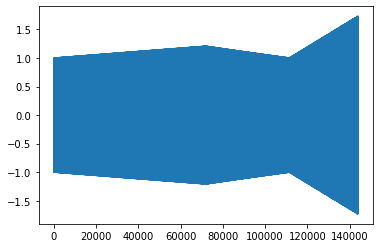

In [122]:
### TEST WAVE SHAPE MORPHING ###
N = num_samples_for_secs(3)
test_dict = {
    'wave_idx': np.linspace(WAVE_SIN, WAVE_SAW, N),
    'mode': const_inp(0, N),
    'coarse_adj': const_inp(0.015, N),
    'fine_adj': const_inp(0, N),
    'vpo': const_inp(0, N),
    'fm_exp': const_inp(0, N),
}
gen_test(test_dict, N)